## ARIMA Forecasting 

Concept: Uses past sales (lags + trends) to predict future.<br>
Works on stationary data (no trend/seasonality).<br>
Formula = AR (past values) + MA (past errors) + differencing (trend removal).<br>

In [136]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [137]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [138]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('C:/Users/Admin/NIYOJAN/Data/Synthetic/Training/arima_data.csv', parse_dates=['Date'])

In [140]:
df.sample(10)

,Date,Product_ID,Product_Name,Sales_Qty
1332,2022-09-25,P002,Cough_Syrup,14
316,2022-11-13,P001,Paracetamol_500mg,49
1307,2022-08-31,P002,Cough_Syrup,23
3991,2024-03-07,P004,ORS_Solution,10
1144,2022-03-21,P002,Cough_Syrup,21
1896,2024-04-11,P002,Cough_Syrup,17
620,2023-09-13,P001,Paracetamol_500mg,51
3060,2024-07-19,P003,Vitamin_C,33
3883,2023-11-20,P004,ORS_Solution,8
1292,2022-08-16,P002,Cough_Syrup,28


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5325 entries, 0 to 5324
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5325 non-null   datetime64[ns]
 1   Product_ID    5325 non-null   object        
 2   Product_Name  5325 non-null   object        
 3   Sales_Qty     5325 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 166.5+ KB


In [142]:
df.shape

(5325, 4)

In [143]:
df['Product_Name'].unique()

array(['Paracetamol_500mg', 'Cough_Syrup', 'Vitamin_C', 'ORS_Solution',
       'Antibiotic_A'], dtype=object)

Preprocessing

In [144]:
df.isnull().sum()

Date            0
Product_ID      0
Product_Name    0
Sales_Qty       0
dtype: int64

In [145]:
df.duplicated().sum()

np.int64(0)

In [146]:
# Fill missing Sales_Qty with 0 (assuming no sale)
df['Sales_Qty'] = df['Sales_Qty'].fillna(0)

Plotting Function

In [147]:
def plot_daily_sales(df_product, product_name):
    """
    Plots daily sales of a given product.
    """
    plt.figure(figsize=(12,6))
    plt.plot(df_product['Date'], df_product['Sales_Qty'], marker='o', linestyle='-')
    plt.title(f'Daily Sales of {product_name}')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [148]:
def plot_forecast(df_product, forecast, future_dates, product_name):
    """
    Plots historical sales and 30-day forecast for a product.
    """
    plt.figure(figsize=(12,6))
    plt.plot(df_product['Date'], df_product['Sales_Qty'], label='Historical Sales', marker='o')
    plt.plot(future_dates, forecast, label='30-Day Forecast', color='green', marker='o')
    plt.title(f'30-Day Forecast for {product_name}')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Helper Function: Auto p,q selection from ACF/PACF

In [149]:
def select_p_q(series, max_lag=10):
    """
    Automatically select p (AR) and q (MA) from PACF and ACF plots.
    Returns: p, q
    """
    from statsmodels.tsa.stattools import acf, pacf

    acf_vals = acf(series, nlags=max_lag)
    pacf_vals = pacf(series, nlags=max_lag)

    # p = first lag where PACF drops below significance (~0)
    pacf_threshold = 1.96/np.sqrt(len(series))
    p = np.argmax(np.abs(pacf_vals[1:]) < pacf_threshold) + 1
    if p == 1 and np.abs(pacf_vals[1]) > pacf_threshold:  # fallback
        p = 2

    # q = first lag where ACF drops below significance (~0)
    acf_threshold = 1.96/np.sqrt(len(series))
    q = np.argmax(np.abs(acf_vals[1:]) < acf_threshold) + 1
    if q == 1 and np.abs(acf_vals[1]) > acf_threshold:  # fallback
        q = 2

    return p, q

In [ ]:
model_dir = 'C:/Users/Admin/NIYOJAN/Models/Arima'
os.makedirs(model_dir, exist_ok=True)

In [ ]:
forecast_dir = 'C:/Users/Admin/NIYOJAN/Forecasts/Arima'
os.makedirs(forecast_dir, exist_ok=True)

In [152]:
# Get existing models
saved_models_list = [f.replace('_arima.pkl','') for f in os.listdir(model_dir) if f.endswith('_arima.pkl')]

In [154]:
# List of Products
products = df['Product_Name'].unique()
forecast_all = pd.DataFrame()

Loop through Products


Processing Product: Paracetamol_500mg


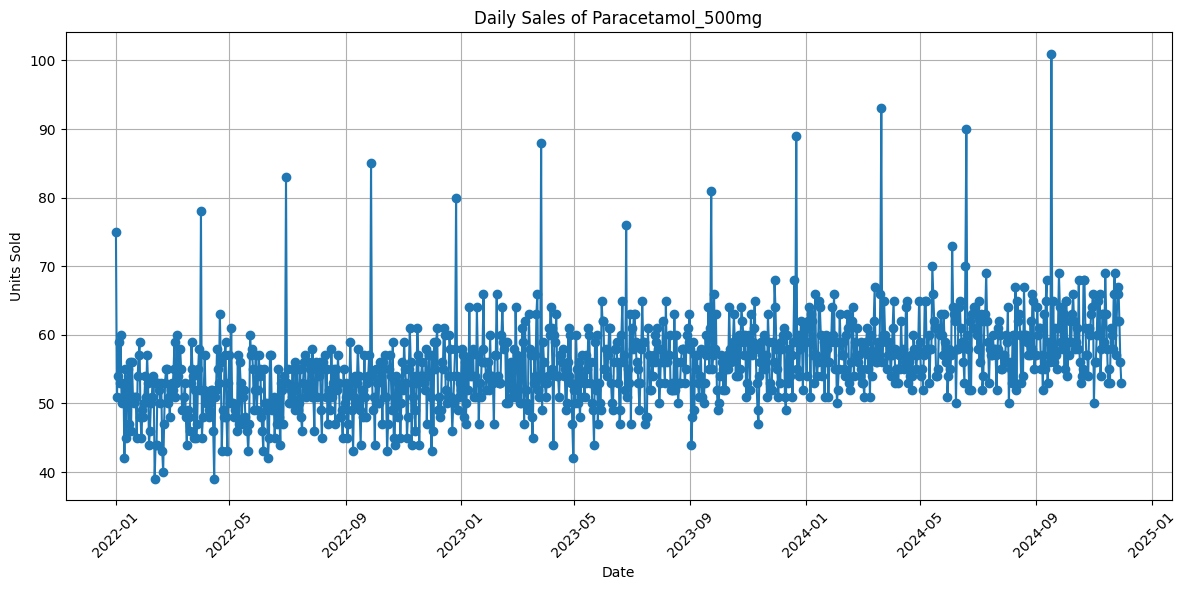

Loaded existing ARIMA model for Paracetamol_500mg


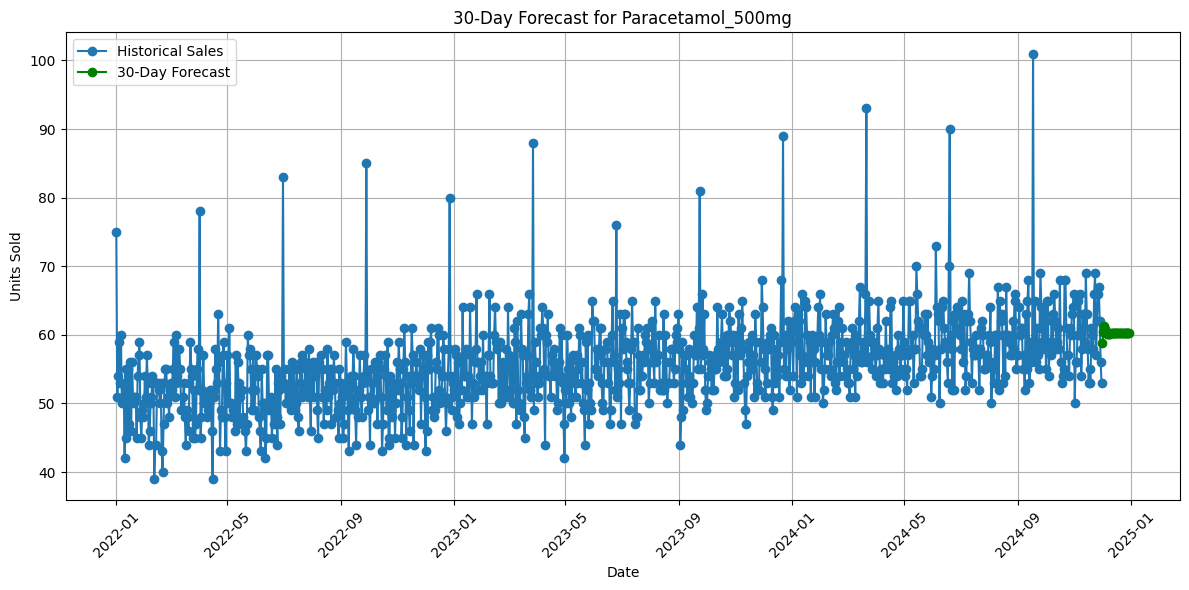


Processing Product: Cough_Syrup


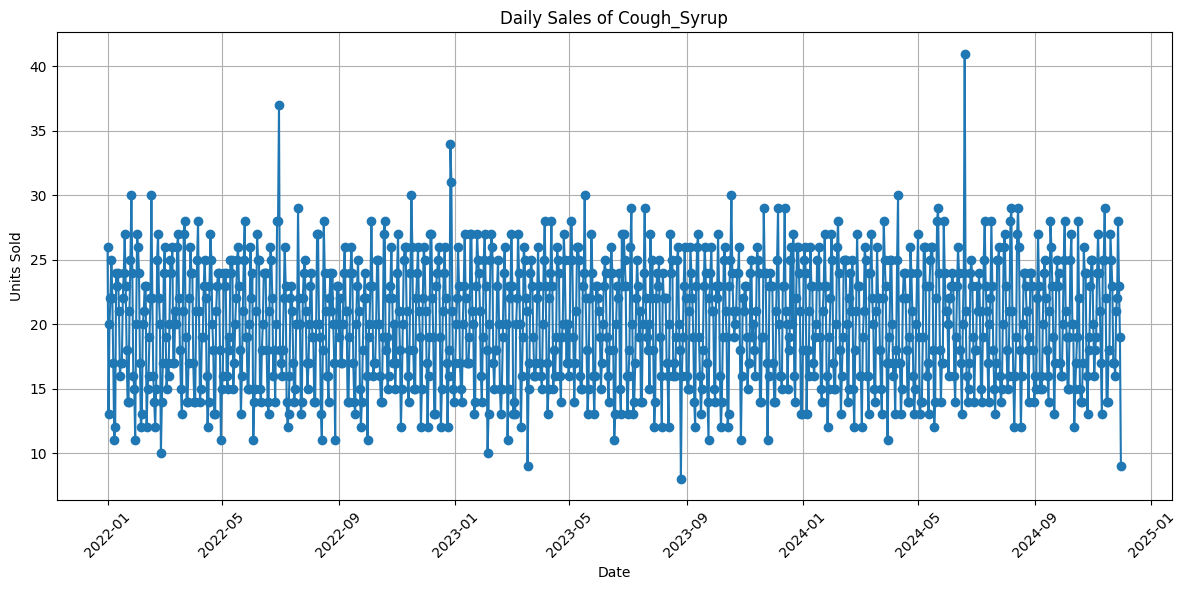

Loaded existing ARIMA model for Cough_Syrup


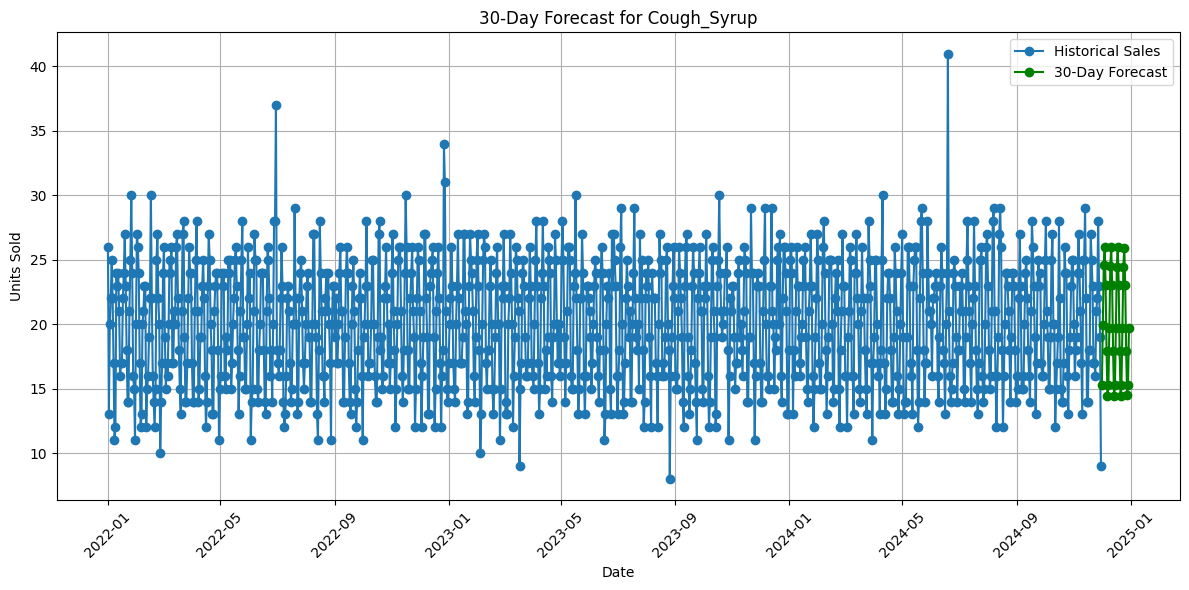


Processing Product: Vitamin_C


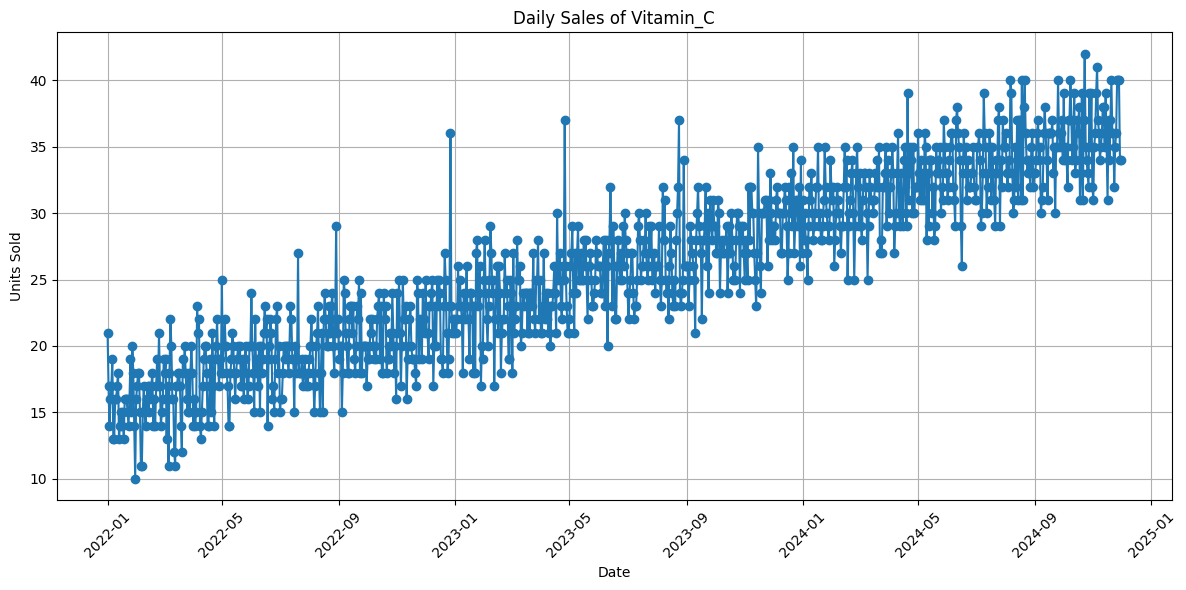

Loaded existing ARIMA model for Vitamin_C


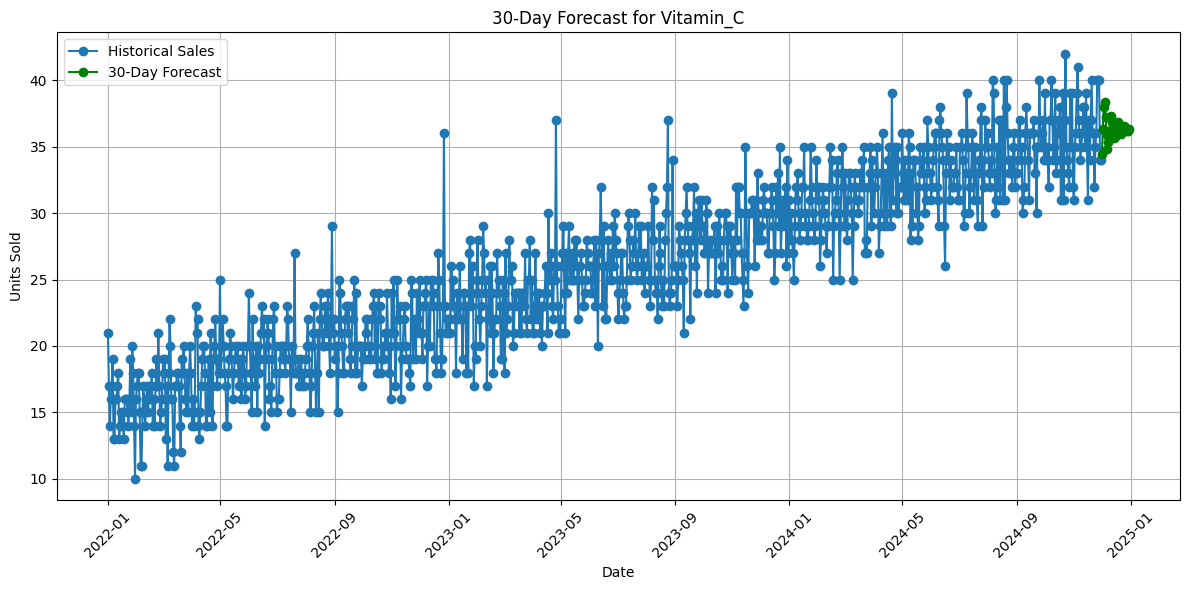


Processing Product: ORS_Solution


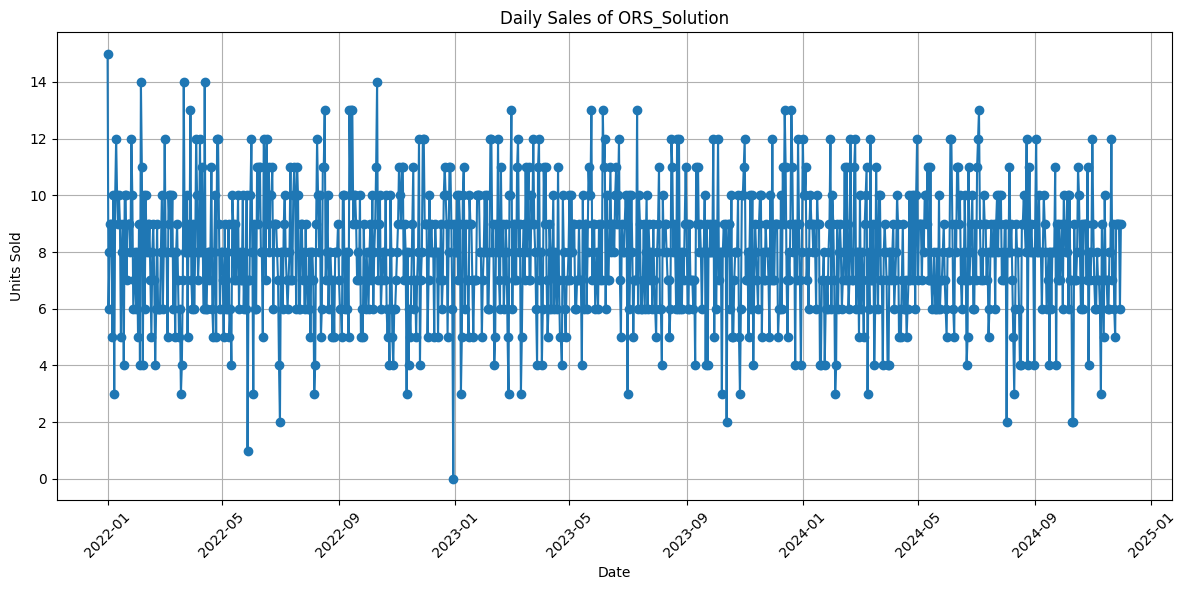

Loaded existing ARIMA model for ORS_Solution


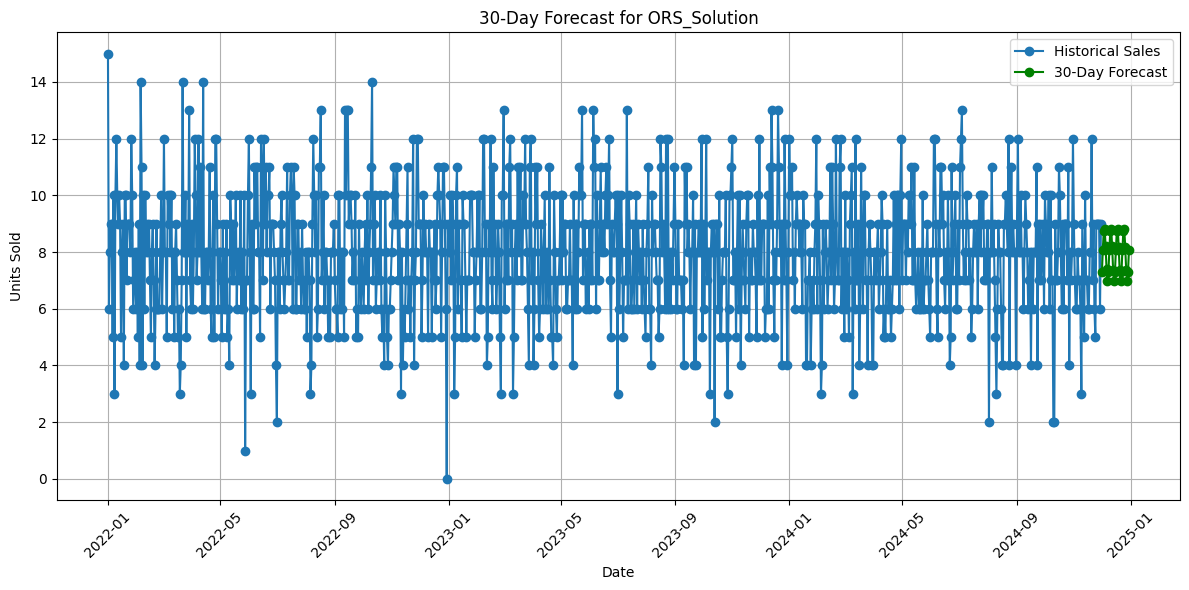


Processing Product: Antibiotic_A


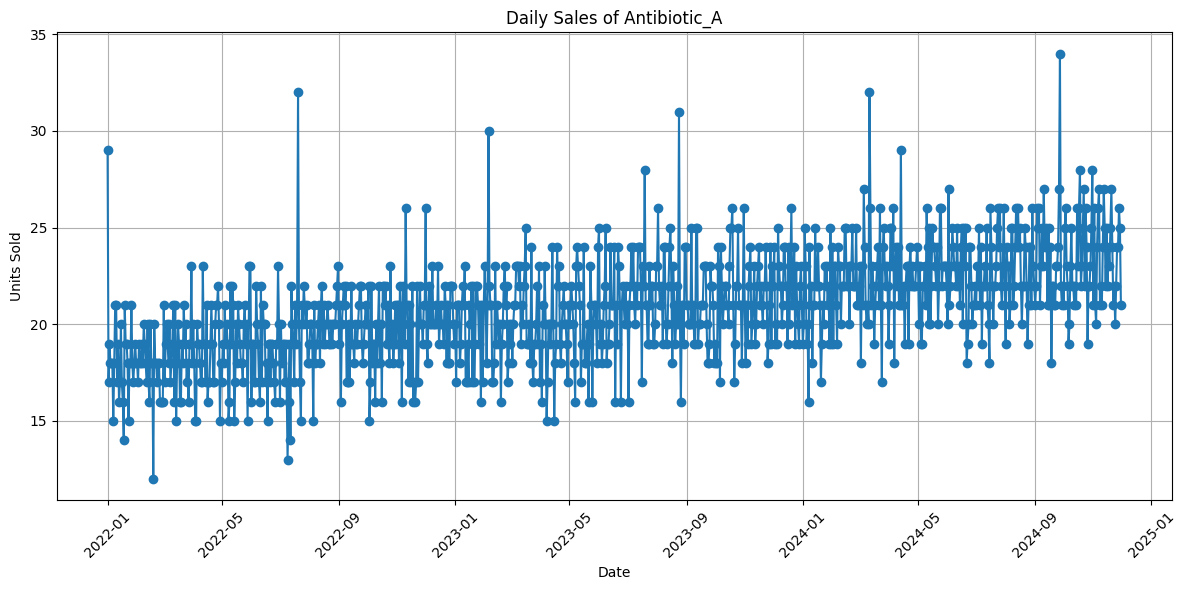

Loaded existing ARIMA model for Antibiotic_A


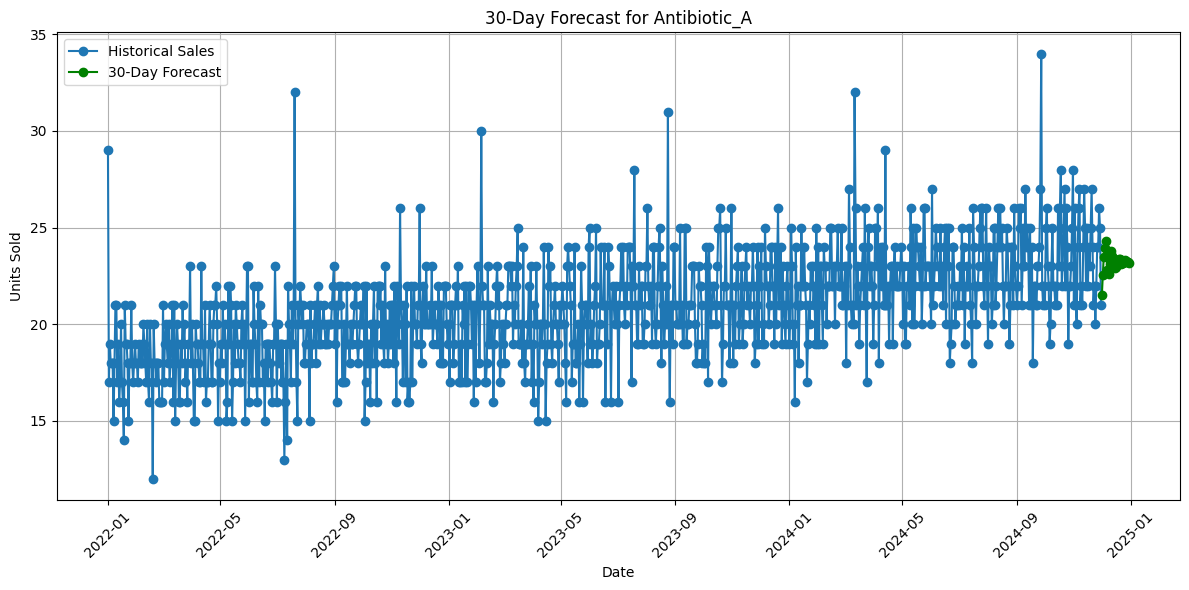

In [155]:
for product in products:
    print(f"\nProcessing Product: {product}")
    product_filename = product.replace(' ', '_')
    
    # Aggregate daily sales
    df_product = df[df['Product_Name']==product].groupby('Date')['Sales_Qty'].sum().reset_index()
    
    # Plot historical sales
    plot_daily_sales(df_product, product)
    
    # Train-Test split (if needed)
    train = df_product
    
    # Check if model exists
    if product_filename in saved_models_list:
        # Load existing model
        with open(os.path.join(model_dir, f"{product_filename}_arima.pkl"), 'rb') as f:
            model_fit = pickle.load(f)
        print(f"Loaded existing ARIMA model for {product}")
        forecast = model_fit.forecast(steps=30)
    else:
        # New product → check data length
        if len(df_product) < 30:
            # Fallback forecast: use mean sales
            avg_sales = df_product['Sales_Qty'].mean()
            forecast = [avg_sales]*30
            print(f"Not enough history for {product}, using fallback forecast")
        else:
            # Stationarity check (ADF)
            result = adfuller(train['Sales_Qty'])
            d = 1 if result[1] > 0.05 else 0
            
            # Auto select p,q
            p, q = select_p_q(train['Sales_Qty'])
            print(f"Selected ARIMA order: p={p}, d={d}, q={q}")
            
            # Train ARIMA
            model = ARIMA(train['Sales_Qty'], order=(p,d,q))
            model_fit = model.fit()
            
            # Save model
            model_path = os.path.join(model_dir, f"{product_filename}_arima.pkl")
            with open(model_path, 'wb') as f:
                pickle.dump(model_fit, f)
            print(f"Model saved as {model_path}")
            
            # Forecast next 30 days
            forecast = model_fit.forecast(steps=30)
    
    # Future dates
    last_date = df_product['Date'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
    
    # Store forecast
    temp_forecast = pd.DataFrame({
    'Date': future_dates,
    'Product': product,
    'Model': 'ARIMA',
    'Forecast': forecast,
    'Actual': None   # Future actuals are unknown
    })
    forecast_all = pd.concat([forecast_all, temp_forecast], ignore_index=True)
    
    # Plot forecast
    plot_forecast(df_product, forecast, future_dates, product)


In [156]:
forecast_all.sample(10)

,Date,Product,Model,Forecast,Actual
127,2024-12-08,Antibiotic_A,ARIMA,22.741592,None
140,2024-12-21,Antibiotic_A,ARIMA,23.184258,None
1,2024-12-02,Paracetamol_500mg,ARIMA,60.399237,None
78,2024-12-19,Vitamin_C,ARIMA,36.555631,None
62,2024-12-03,Vitamin_C,ARIMA,37.997651,None
84,2024-12-25,Vitamin_C,ARIMA,36.557202,None
124,2024-12-05,Antibiotic_A,ARIMA,24.316448,None
39,2024-12-10,Cough_Syrup,ARIMA,24.484693,None
130,2024-12-11,Antibiotic_A,ARIMA,23.779664,None
139,2024-12-20,Antibiotic_A,ARIMA,23.369857,None


In [ ]:
test_df=pd.read_csv("C:/Users/Admin/NIYOJAN/Data/Synthetic/Test/arima_data.csv")

In [158]:
test_df.head()

,Date,Product_ID,Product_Name,Sales_Qty
0,2024-12-01,P001,Paracetamol_500mg,58
1,2024-12-02,P001,Paracetamol_500mg,57
2,2024-12-03,P001,Paracetamol_500mg,67
3,2024-12-04,P001,Paracetamol_500mg,63
4,2024-12-05,P001,Paracetamol_500mg,68


In [159]:
test_df.shape

(150, 4)

In [160]:
forecast_all.head()

,Date,Product,Model,Forecast,Actual
0,2024-12-01,Paracetamol_500mg,ARIMA,58.798008,None
1,2024-12-02,Paracetamol_500mg,ARIMA,60.399237,None
2,2024-12-03,Paracetamol_500mg,ARIMA,61.298039,None
3,2024-12-04,Paracetamol_500mg,ARIMA,60.914546,None
4,2024-12-05,Paracetamol_500mg,ARIMA,60.482260,None


In [161]:
forecast_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      150 non-null    datetime64[ns]
 1   Product   150 non-null    object        
 2   Model     150 non-null    object        
 3   Forecast  150 non-null    float64       
 4   Actual    0 non-null      object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 6.0+ KB


In [162]:
# Convert forecast Date to datetime (if not already)
forecast_all['Date'] = pd.to_datetime(forecast_all['Date'])

# Convert actuals Date to datetime
test_df['Date'] = pd.to_datetime(test_df['Date'])

In [163]:
print(test_df['Date'].min(), test_df['Date'].max())
print(forecast_all['Date'].min(), forecast_all['Date'].max())

2024-12-01 00:00:00 2024-12-30 00:00:00
2024-12-01 00:00:00 2024-12-30 00:00:00


In [164]:
forecast_all['Product'] = forecast_all['Product'].str.strip()
test_df['Product_Name'] = test_df['Product_Name'].str.strip()
forecast_all.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      150 non-null    datetime64[ns]
 1   Product   150 non-null    object        
 2   Model     150 non-null    object        
 3   Forecast  150 non-null    float64       
 4   Actual    0 non-null      object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 6.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          150 non-null    datetime64[ns]
 1   Product_ID    150 non-null    object        
 2   Product_Name  150 non-null    object        
 3   Sales_Qty     150 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.8+ KB


In [165]:
forecast_all = forecast_all.merge(test_df[['Date','Product_Name','Sales_Qty']], 
                                left_on=['Date','Product'],
                                right_on=['Date','Product_Name'],
                                how='left')
forecast_all['Actual'] = forecast_all['Sales_Qty']

In [167]:
forecast_all.drop(['Product_Name','Sales_Qty'], axis=1, inplace=True)

In [168]:
forecast_all.sample(10)

,Date,Product,Model,Forecast,Actual
119,2024-12-30,ORS_Solution,ARIMA,8.081259,7
44,2024-12-15,Cough_Syrup,ARIMA,15.255755,16
92,2024-12-03,ORS_Solution,ARIMA,8.749375,7
47,2024-12-18,Cough_Syrup,ARIMA,25.958554,25
26,2024-12-27,Paracetamol_500mg,ARIMA,60.217006,51
9,2024-12-10,Paracetamol_500mg,ARIMA,60.220767,68
41,2024-12-12,Cough_Syrup,ARIMA,23.044094,24
96,2024-12-07,ORS_Solution,ARIMA,6.980178,7
122,2024-12-03,Antibiotic_A,ARIMA,23.489988,26
85,2024-12-26,Vitamin_C,ARIMA,36.462579,38


In [169]:
forecast_file = os.path.join(forecast_dir, "arima_forecast.csv")
forecast_all.to_csv(forecast_file, index=False)